# Training and evaluating multiple models in parallel

Often we need to train multiple copies of the same model in parallel. This is easy in Feedbax, thanks to the tools that JAX and Equinox provide for vectorization.

!!! NOTE     
    Training model replicates is [handled automatically](/feedbax/examples/0_train_simple#training-multiple-model-simultaneously) if you're using a pre-built model-task pairing.

Let's see an example of training multiple replicates of the same model, that differ only in their random initializations. We'll start with a function that constructs a model, given some parameters and a random key. We'll use the pre-built [`point_mass_nn`][feedbax.xabdeef.models.point_mass_nn], but you could also write your own like we did in [an earlier example](/feedbax/examples/1_train/#building-the-model-ourselves-using-core-feedbax).

In [1]:
from feedbax.xabdeef.models import point_mass_nn

We'll also need a task to train our models on.

In [2]:
from feedbax.task import SimpleReaches

from feedbax.xabdeef.losses import simple_reach_loss

task = SimpleReaches(
    loss_func=simple_reach_loss(),
    workspace=((-1., -1.),  # ((x_min, y_min),
               (1., 1.)),   #  (x_max, y_max))
    n_steps=100,
)

To start, construct a single model, like we've done before.

In [3]:
import jax.random as jr

key_init, key_train, key_eval = jr.split(jr.PRNGKey(0), 3)

model = point_mass_nn(task, key=key_init)

## Constructing an ensemble

To construct multiple replicates of the model at once, use the method [`get_ensemble`][feedbax.get_ensemble]:

In [9]:
n_replicates = 5

from feedbax import get_ensemble

models = get_ensemble(
    point_mass_nn,
    task,  # We need to pass anything we would need to pass to `point_mass_nn`
    dt=0.05,  # We can also pass keyword arguments that `point_mass_nn` accepts
    n_ensemble=n_replicates,
    key=key_init,
)

??? Info "How does `get_ensemble` work?"
    Here's how it's defined:    

    ```python
    def get_ensemble(
        func: Callable[..., PyTree[Any, 'S']], 
        *args, 
        # The rest are keyword arguments.
        n_ensemble: int, 
        key: PRNGKeyArray,
        **kwargs,
    ) -> PyTree[Any, 'S']:
        """Vmap a function over a set of random keys.
        
        Arguments:
            func: A function that returns a PyTree, and whose final argument is a key.
            n_ensemble: The number of keys to split; i.e. the size of the batch
                dimensions in the array leaves of the returned PyTree.
            *args: The positional arguments to `func`.
            key: The key to split to perform the vmap.
        """
        keys = jr.split(key, n_ensemble)  # 1
        func_ = lambda key: func(*args, **kwargs, key=key)  # 2
        return eqx.filter_vmap(func_)(keys)  # 3
    ```

    1. Get a random key for each member of the ensemble. When `func` returns a model, this ensures each model replicate is initialized differently.
    2. Use `lambda` to produce a function that takes only a key, and calls the original function with all its arguments.
    3. Use `vmap` to obtain a vectorized function. Pass it all the keys at once, to obtain all the model replicates at once.
    
    See the [Equinox documentation](https://docs.kidger.site/equinox/tricks/#ensembling) for a similar implementation of ensembling.


The replicated models are all stored in a single object. Consider the single model we constructed earlier:

In [5]:
model

Iterator(
  _step=SimpleFeedback(
    net=SimpleStagedNetwork(
      hidden=GRUCell(
        weight_ih=f32[150,8],
        weight_hh=f32[150,50],
        bias=f32[150],
        bias_n=f32[50],
        input_size=8,
        hidden_size=50,
        use_bias=True
      ),
      hidden_size=50,
      hidden_noise_std=None,
      hidden_nonlinearity=<function identity_func>,
      out_size=2,
      out_nonlinearity=<function identity_func>,
      readout=Linear(
        weight=f32[2,50],
        bias=f32[2],
        in_features=50,
        out_features=2,
        use_bias=True
      ),
      encoding_size=None,
      encoder=None,
      intervenors={
        'hidden':
        [],
        'hidden_nonlinearity':
        [],
        'readout':
        [],
        'out_nonlinearity':
        []
      }
    ),
    mechanics=Mechanics(
      plant=DirectForceInput(
        skeleton=PointMass(mass=1.0),
        clip_states=True,
        intervenors={'clip_skeleton_state': []}
      ),
      dt=0.0

When we use `vmap` to construct multiple models at once, the result is essentially the same: a single object, with the same structure. However, each parameter in the [PyTree](/feedbax/examples/pytrees/) of the model now has a new leading dimension of size 5:

In [6]:
models

Iterator(
  _step=SimpleFeedback(
    net=SimpleStagedNetwork(
      hidden=GRUCell(
        weight_ih=f32[5,150,8],
        weight_hh=f32[5,150,50],
        bias=f32[5,150],
        bias_n=f32[5,50],
        input_size=8,
        hidden_size=50,
        use_bias=True
      ),
      hidden_size=50,
      hidden_noise_std=None,
      hidden_nonlinearity=<function identity_func>,
      out_size=2,
      out_nonlinearity=<function identity_func>,
      readout=Linear(
        weight=f32[5,2,50],
        bias=f32[5,2],
        in_features=50,
        out_features=2,
        use_bias=True
      ),
      encoding_size=None,
      encoder=None,
      intervenors={
        'hidden':
        [],
        'hidden_nonlinearity':
        [],
        'readout':
        [],
        'out_nonlinearity':
        []
      }
    ),
    mechanics=Mechanics(
      plant=DirectForceInput(
        skeleton=PointMass(mass=1.0),
        clip_states=True,
        intervenors={'clip_skeleton_state': []}
      ),



This is nice.

1. Similar parameters are all stored together;
2. Overhead is kept to a minimum because we don't (say) construct our model ensemble as a list with 5 model objects in it, each with their own redundant copies of non-replicated parts of the model.

## Training an ensemble of models

To train all these models at once, we can pass them to a `TaskTrainer` instance along with the argument `ensembled=True`.

In [10]:
import optax

from feedbax.train import TaskTrainer

trainer = TaskTrainer(
    optimizer=optax.adam(learning_rate=1e-2),
    checkpointing=True,
)

models, train_history = trainer(
    task=task,
    model=models,
    ensembled=True,
    n_batches=1000,
    batch_size=250,
    log_step=200,
    where_train=lambda model: model.step.net,
    key=key_train,
)

Training step compiled in 1.91 seconds.
Validation step compiled in 0.95 seconds.


train batch:   0%|          | 0/1000 [00:00<?, ?it/s]


Training iteration: 0
	mean training loss: 4.02e+01
	mean validation loss: 9.06e+00

Training iteration: 200
	mean training loss: 9.36e-03
	mean validation loss: 1.74e-03

Training iteration: 400
	mean training loss: 5.22e-03
	mean validation loss: 9.69e-04

Training iteration: 600
	mean training loss: 4.06e-03
	mean validation loss: 8.08e-04

Training iteration: 800
	mean training loss: 3.33e-03
	mean validation loss: 7.23e-04

Training iteration: 999
	mean training loss: 2.87e-03
	mean validation loss: 6.69e-04

Completed training run on a total of 250,000 trials per model.


Plot the mean and standard deviation of the loss term histories, across the replicates:

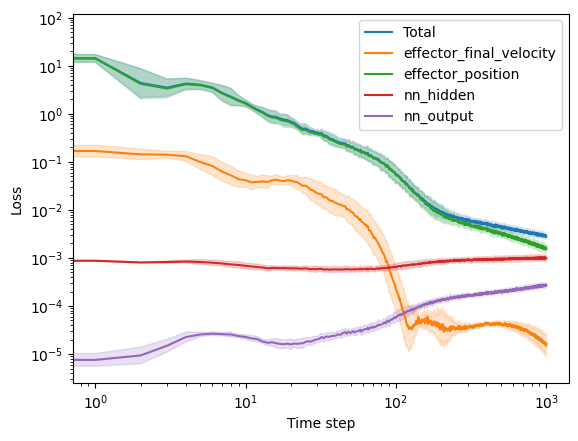

In [11]:
from feedbax.plot import plot_loss_mean_history

_ = plot_loss_mean_history(train_history)

## Evaluating an ensemble

Every task provides a method `eval_ensemble` which can evaluate all the models in an ensemble at once, on the validation task:

In [12]:
states = task.eval_ensemble(models, n_replicates, key_eval)

Notice that the arrays in `states` have a leading dimension of size 5, like `models` did.

In [13]:
states

SimpleFeedbackState(
  mechanics=MechanicsState(
    plant=PlantState(
      skeleton=CartesianState(
        pos=f32[5,7,100,2],
        vel=f32[5,7,100,2],
        force=f32[5,7,100,2]
      ),
      muscles=None
    ),
    effector=CartesianState(
      pos=f32[5,7,100,2],
      vel=f32[5,7,100,2],
      force=f32[5,7,100,2]
    ),
    solver=None
  ),
  net=NetworkState(hidden=f32[5,7,100,50], output=f32[5,7,100,2], encoding=None),
  feedback=ChannelState(
    output=(f32[5,7,100,2], f32[5,7,100,2]),
    queue=((f32[5,7,100,2], f32[5,7,100,2]),),
    noise=(f32[5,7,100,2], f32[5,7,100,2])
  )
)

To be clear, that's 5 model replicates evaluated on 7 validation trials, each of which has 100 time points.

## Retrieving a single model from an ensemble

To take just a single model from an ensemble, we can use `tree_take`.

In [14]:
from feedbax import tree_take

model_0 = tree_take(models, 0)

model_0

Iterator(
  _step=SimpleFeedback(
    net=SimpleStagedNetwork(
      hidden=GRUCell(
        weight_ih=f32[150,8],
        weight_hh=f32[150,50],
        bias=f32[150],
        bias_n=f32[50],
        input_size=8,
        hidden_size=50,
        use_bias=True
      ),
      hidden_size=50,
      hidden_noise_std=None,
      hidden_nonlinearity=<function identity_func>,
      out_size=2,
      out_nonlinearity=<function identity_func>,
      readout=Linear(
        weight=f32[2,50],
        bias=f32[2],
        in_features=50,
        out_features=2,
        use_bias=True
      ),
      encoding_size=None,
      encoder=None,
      intervenors={
        'hidden':
        [],
        'hidden_nonlinearity':
        [],
        'readout':
        [],
        'out_nonlinearity':
        []
      }
    ),
    mechanics=Mechanics(
      plant=DirectForceInput(
        skeleton=PointMass(mass=1.0),
        clip_states=True,
        intervenors={'clip_skeleton_state': []}
      ),
      dt=0.0

The leading dimension is gone from all the arrays, and `model_0` looks just like the single `model`.

States can be similarly indexed using `tree_take`.

In [15]:
states_2 = tree_take(states, 2)

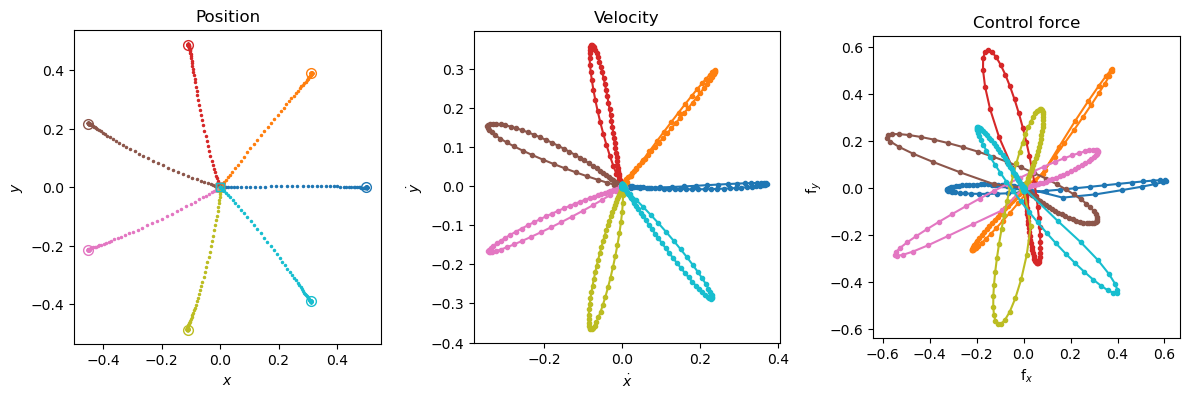

In [16]:
from feedbax.plot import plot_reach_trajectories

_ = plot_reach_trajectories(states_2, trial_specs=task.validation_trials)